# Cab-Driver Agent

#### <font color='green'>Author</font>
- Md Junaid Alam

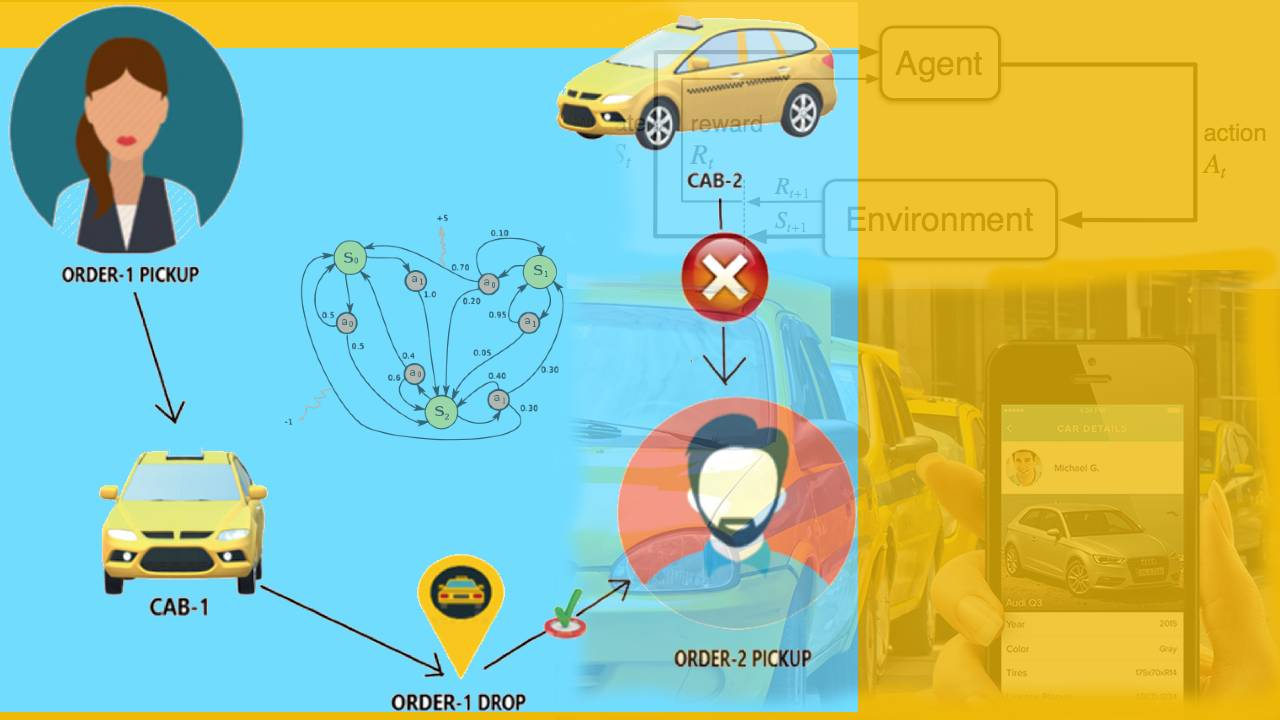

In [ ]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [ ]:
# If we want to save the entire model in a directory, then check if that directory exists, else create
import os
saved_model_directory = 'saved_model'
saved_model_file = "model_weights" # File name for saved model pkl file and h5 file
if not os.path.exists(saved_model_directory):
    os.makedirs(saved_model_directory)

#### Defining Time Matrix

In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [ ]:
# Check the Time_matrix dimension
Time_matrix.shape

(5, 5, 24, 7)

The time matrix is a 4d numpy array with dimensions as start location, end location, hour of the day and day of the week

In [ ]:
# Let us check the time duration for start location 2, end location 4, hour of day 1 and day of the week as 3
Time_matrix[2][4][1][3]

2.0

#### Tracking the state-action pairs for checking convergence


In [ ]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### We will be using Architecture 1 of DQN

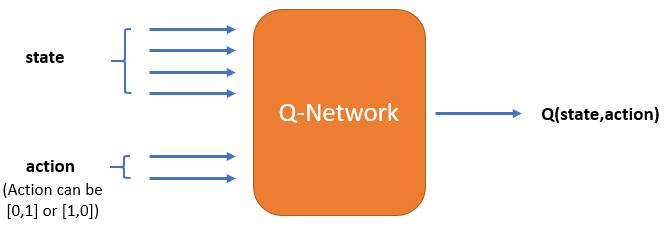

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1 ##
        self.epsilon_decay = -0.002 #for 15k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        ## Declare and Initialize the value of the states tracked
        self.states_tracked = [] 
        
        ## We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        ## Add an output layer with size action_size
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state_actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment 
        
        state = state_actions[0]
        actions = state_actions[1]
        if np.random.rand() <= self.epsilon:  # perform exploration of random ride requests
            return random.choice(actions)
        else:  # Perform exploitation
            # Reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, state_size)
            q_values = self.model.predict(state) # Predict Q values using the model
            # truncate the array to only those actions that are part of the ride  requests.
            possible_q_values = [q_values[0][i] for i in actions]
            return actions[np.argmax(possible_q_values)]

    def append_sample(self, state, action, reward, next_state, isTerminalState):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory. In addition a terminal state isTerminalState is added
        self.memory.append((state, action, reward, next_state, isTerminalState))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size)) # Initialize the input matrix with 0 values
            update_output = np.zeros((self.batch_size, self.state_size)) # Initialize the output matrix with 0 values
            actions, rewards = [], []
            terminal_states = []

            # populate update_input and update_output and the lists rewards, actions,terminal_state
            for i in range(self.batch_size):
                state, action, reward, next_state, isTerminalState = mini_batch[i]
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(isTerminalState)
                #3. Update your 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch1(state)     
                update_output[i] = env.state_encod_arch1(next_state)

            #1. Predict the target from earlier model
            target = self.model.predict(update_input)
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            for i in range(self.batch_size):
                if(terminal_states[i]):
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tracking for state(0,0,0) and action of (0,2)
        q_values = self.model.predict(self.track_state)
        # Get the q_value of the action index that we are tracking.
        self.states_tracked.append(q_values[0][2])
    
    def save(self, name):
        self.model.save(name)
        
    def get_model_weights(self):
        return self.model.get_weights()

In [ ]:
Episodes = 5000

### DQN block

In [ ]:
# Encodings for color and format of string to format our output (only for beautfying purpose)
GREEN = '\033[92m'
BOLD = '\033[1m'
END = '\033[0m'
message = BOLD+GREEN+"For episode {0} reward is {1}, memory consumed {2}, epsilon {3} time taken {4}"+END
time_message = BOLD+"Total time consumed: {0}"+END

In [ ]:
import time
episode_time = 24*30 #30 days before which car has to be recharged
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []
# list to track the score
score_tracked = []

In [ ]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    terminal_state = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        state_action = [state, possible_actions_indices]
        #action = agent.get_action(state, possible_actions_indices)
        action = agent.get_action(state_action)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state,  env.action_space[action], Time_matrix)

        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            terminal_state = True
      
        # 5. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        # 6. Train the model by calling function agent.train_model
        agent.train_model()
        # 7. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print(message.format(episode, score, len(agent.memory), agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving the model for episode {}".format(episode))
        save_obj(agent.get_model_weights(), name=saved_model_file)
        agent.save(saved_model_directory) # This will save the model in saved_model directory (Optional)
        #agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(time_message.format(elapsed_time))

Saving the model for episode 0
INFO:tensorflow:Assets written to: saved_model\assets
For episode 9 reward is -292.0, memory consumed 1406, epsilon 0.9821612107479771 time taken 728.0
For episode 19 reward is -426.0, memory consumed 2000, epsilon 0.9627133137617906 time taken 726.0
For episode 29 reward is 86.0, memory consumed 2000, epsilon 0.9436505109373241 time taken 728.0
For episode 39 reward is -186.0, memory consumed 2000, epsilon 0.9249651768992738 time taken 732.0
For episode 49 reward is -290.0, memory consumed 2000, epsilon 0.9066498372648834 time taken 724.0
For episode 59 reward is -117.0, memory consumed 2000, epsilon 0.8886971656540912 time taken 729.0
For episode 69 reward is -103.0, memory consumed 2000, epsilon 0.8710999807588808 time taken 728.0
For episode 79 reward is -296.0, memory consumed 2000, epsilon 0.853851243470662 time taken 727.0
For episode 89 reward is -130.0, memory consumed 2000, epsilon 0.8369440540645332 time taken 728.0
For episode 99 reward is -19

For episode 739 reward is 123.0, memory consumed 2000, epsilon 0.2281011384054325 time taken 726.0
For episode 749 reward is 484.0, memory consumed 2000, epsilon 0.22358463125803243 time taken 724.0
For episode 759 reward is 337.0, memory consumed 2000, epsilon 0.2191575569441704 time taken 721.0
For episode 769 reward is 250.0, memory consumed 2000, epsilon 0.21481814457509246 time taken 724.0
For episode 779 reward is 664.0, memory consumed 2000, epsilon 0.21056465832799132 time taken 724.0
For episode 789 reward is 238.0, memory consumed 2000, epsilon 0.20639539675165422 time taken 721.0
For episode 799 reward is 484.0, memory consumed 2000, epsilon 0.2023086920858598 time taken 724.0
For episode 809 reward is 129.0, memory consumed 2000, epsilon 0.19830290959425156 time taken 723.0
For episode 819 reward is 754.0, memory consumed 2000, epsilon 0.19437644691042175 time taken 724.0
For episode 829 reward is 487.0, memory consumed 2000, epsilon 0.19052773339694326 time taken 727.0
For

For episode 1459 reward is 893.0, memory consumed 2000, epsilon 0.054051122197652735 time taken 725.0
For episode 1469 reward is 710.0, memory consumed 2000, epsilon 0.05298103628214745 time taken 722.0
For episode 1479 reward is 701.0, memory consumed 2000, epsilon 0.05193213948744494 time taken 722.0
For episode 1489 reward is 1361.0, memory consumed 2000, epsilon 0.05090401224084182 time taken 725.0
For episode 1499 reward is 666.0, memory consumed 2000, epsilon 0.049896243277730915 time taken 729.0
For episode 1509 reward is 1074.0, memory consumed 2000, epsilon 0.048908429477089885 time taken 723.0
For episode 1519 reward is 632.0, memory consumed 2000, epsilon 0.04794017570022743 time taken 725.0
For episode 1529 reward is 1269.0, memory consumed 2000, epsilon 0.046991094632722614 time taken 729.0
For episode 1539 reward is -77.0, memory consumed 2000, epsilon 0.04606080662949385 time taken 730.0
For episode 1549 reward is 858.0, memory consumed 2000, epsilon 0.0451489395629358 t

For episode 2169 reward is 988.0, memory consumed 2000, epsilon 0.013072496724018244 time taken 724.0
For episode 2179 reward is 1183.0, memory consumed 2000, epsilon 0.012813841958956525 time taken 730.0
For episode 2189 reward is 930.0, memory consumed 2000, epsilon 0.012560308901398549 time taken 723.0
For episode 2199 reward is 1250.0, memory consumed 2000, epsilon 0.012311796134740824 time taken 722.0
For episode 2209 reward is 1000.0, memory consumed 2000, epsilon 0.01206820425056312 time taken 727.0
For episode 2219 reward is 1640.0, memory consumed 2000, epsilon 0.011829435808863854 time taken 725.0
For episode 2229 reward is 1079.0, memory consumed 2000, epsilon 0.011595395299082701 time taken 722.0
For episode 2239 reward is 390.0, memory consumed 2000, epsilon 0.011365989101895187 time taken 723.0
For episode 2249 reward is -23.0, memory consumed 2000, epsilon 0.011141125451763628 time taken 721.0
For episode 2259 reward is 1394.0, memory consumed 2000, epsilon 0.01092071440

For episode 2879 reward is 1165.0, memory consumed 2000, epsilon 0.0031673885538668297 time taken 721.0
For episode 2889 reward is 974.0, memory consumed 2000, epsilon 0.003104868071614199 time taken 725.0
For episode 2899 reward is 1354.0, memory consumed 2000, epsilon 0.003043585577855676 time taken 721.0
For episode 2909 reward is 1296.0, memory consumed 2000, epsilon 0.002983516558776639 time taken 729.0
For episode 2919 reward is 1642.0, memory consumed 2000, epsilon 0.0029246369859685308 time taken 721.0
For episode 2929 reward is 1200.0, memory consumed 2000, epsilon 0.002866923306817153 time taken 723.0
For episode 2939 reward is 1177.0, memory consumed 2000, epsilon 0.0028103524350813224 time taken 724.0
For episode 2949 reward is 1054.0, memory consumed 2000, epsilon 0.002754901741658055 time taken 727.0
For episode 2959 reward is 1392.0, memory consumed 2000, epsilon 0.0027005490455306266 time taken 726.0
For episode 2969 reward is 978.0, memory consumed 2000, epsilon 0.0026

For episode 3579 reward is 246.0, memory consumed 2000, epsilon 0.0007886024313675394 time taken 723.0
For episode 3589 reward is 1596.0, memory consumed 2000, epsilon 0.0007731850702598763 time taken 723.0
For episode 3599 reward is -366.0, memory consumed 2000, epsilon 0.0007580729933562533 time taken 723.0
For episode 3609 reward is 1120.0, memory consumed 2000, epsilon 0.0007432601556244129 time taken 721.0
For episode 3619 reward is 1016.0, memory consumed 2000, epsilon 0.0007287406317317542 time taken 722.0
For episode 3629 reward is 1849.0, memory consumed 2000, epsilon 0.0007145086136751249 time taken 721.0
For episode 3639 reward is 593.0, memory consumed 2000, epsilon 0.0007005584084575385 time taken 722.0
For episode 3649 reward is 1148.0, memory consumed 2000, epsilon 0.000686884435810904 time taken 728.0
For episode 3659 reward is 1462.0, memory consumed 2000, epsilon 0.0006734812259638393 time taken 721.0
For episode 3669 reward is 1700.0, memory consumed 2000, epsilon 0.

For episode 4279 reward is 1506.0, memory consumed 2000, epsilon 0.00020200099569278831 time taken 723.0
For episode 4289 reward is 210.0, memory consumed 2000, epsilon 0.00019819912125164724 time taken 732.0
For episode 4299 reward is 1196.0, memory consumed 2000, epsilon 0.00019447252896836155 time taken 722.0
For episode 4309 reward is 1133.0, memory consumed 2000, epsilon 0.00019081972815633005 time taken 722.0
For episode 4319 reward is 1308.0, memory consumed 2000, epsilon 0.00018723925764652295 time taken 732.0
For episode 4329 reward is 1426.0, memory consumed 2000, epsilon 0.00018372968520299606 time taken 721.0
For episode 4339 reward is 1394.0, memory consumed 2000, epsilon 0.00018028960694997672 time taken 722.0
For episode 4349 reward is 394.0, memory consumed 2000, epsilon 0.0001769176468102961 time taken 724.0
For episode 4359 reward is 1325.0, memory consumed 2000, epsilon 0.00017361245595493783 time taken 725.0
For episode 4369 reward is 1475.0, memory consumed 2000, e

For episode 4979 reward is 1525.0, memory consumed 2000, epsilon 5.7346862611607045e-05 time taken 721.0
For episode 4989 reward is -32.0, memory consumed 2000, epsilon 5.640933191713446e-05 time taken 721.0
For episode 4999 reward is 1290.0, memory consumed 2000, epsilon 5.5490365574228074e-05 time taken 723.0
Total time consumed: 83409.00548028946


In [ ]:
#save the final model and the weights of the model as pkl and h5
save_obj(agent.get_model_weights(), name=saved_model_file)

agent.save(saved_model_directory) # This will save the model in saved_model directory (Optional)
agent.model.save_weights(saved_model_file+".h5") # Saving model weights in .h5 (Optional)

INFO:tensorflow:Assets written to: saved_model\assets


<font color=red>Please note that when saving the model in a directory, it is assumed that write permission is not restricted on the system in which this code is running else it will fail to write. In that case the code to save model can be commented out or write permission granted.</font>

### Tracking Convergence

In [ ]:
# Let us check the states tracked
agent.states_tracked

[1125.0964,
 710.7694,
 16629.326,
 1547.8969,
 534.95325,
 287.93753,
 152.19446,
 97.42023,
 64.427,
 49.16761,
 40.094666,
 60.95359,
 73.096985,
 91.52922,
 104.62765,
 135.78955,
 97.35582,
 142.58871,
 122.71508,
 199.14708,
 347.6722,
 251.21652,
 252.79367,
 338.97235,
 430.32968,
 3838.7373,
 664.76996,
 551.6095,
 421.57947,
 412.8905,
 376.54785,
 328.68823,
 359.25793,
 345.61954,
 450.91888,
 446.80872,
 521.7141,
 411.34573,
 443.87018,
 576.8028,
 808.6539,
 655.3204,
 476.2931,
 354.40088,
 289.4261,
 307.71295,
 342.52795,
 474.8465,
 652.77216,
 1727.715,
 840.0033,
 477.16388,
 393.30615,
 388.57098,
 367.30023,
 380.86755,
 453.03323,
 498.90204,
 454.80478,
 689.5023,
 510.00735,
 433.31436,
 410.54913,
 347.41074,
 463.45074,
 750.55145,
 824.0481,
 770.145,
 652.17334,
 665.2402,
 735.471,
 581.27527,
 538.0231,
 583.52344,
 731.9544,
 638.85205,
 967.5141,
 722.46124,
 764.7713,
 658.39514,
 571.6208,
 507.04608,
 500.92688,
 446.9135,
 355.37573,
 572.6718,
 11

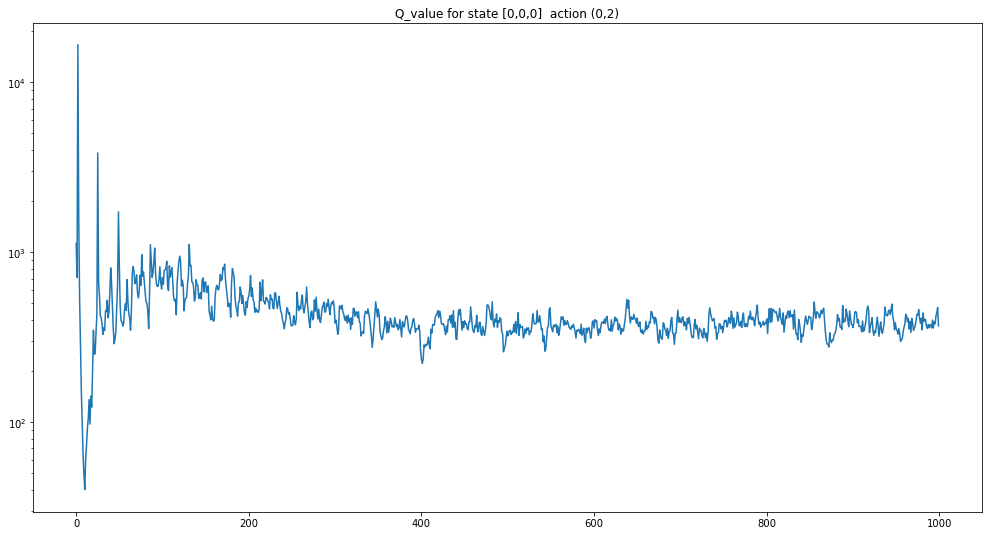

In [ ]:
# plot Qvalue for state and action
plt.figure(0, figsize=(17,9))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### <font color='green'>Hence we observe that the Q value for state action shows to converge</font>

### Tracking Reward per episode

As per the problem statement we can either check for Q-states convergence or we can check for reward per episode stability. Hence let us check for reward per episode.

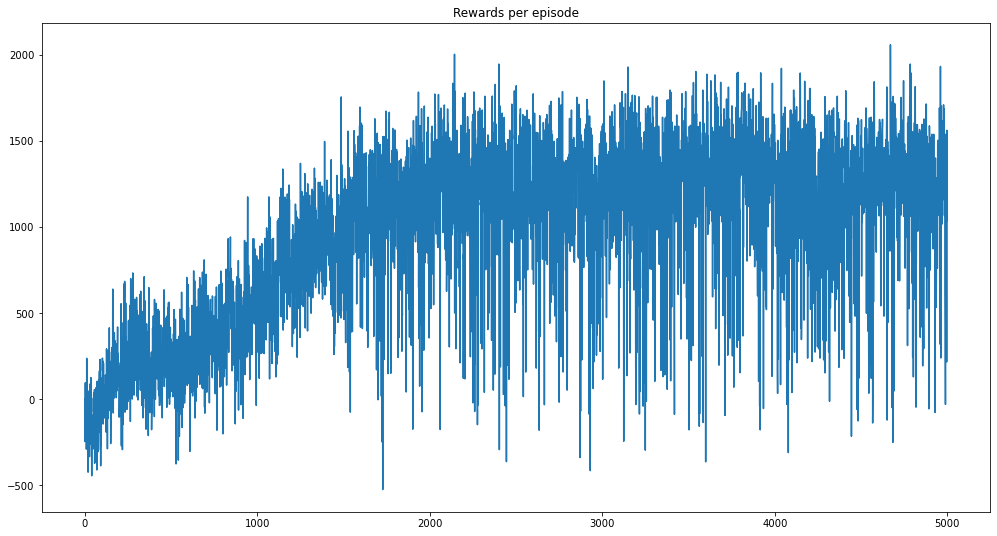

In [ ]:
# Plot the reward per episode
plt.figure(0, figsize=(17,9))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.show()

#### <font color='green'>Hence we observe the convergence happening in the reward per episode</font>

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,5000)
epsilon = []
for i in range(0,5000):
    epsilon.append(0.00001 + (1 - 0.00001) * np.exp(-0.002*i))

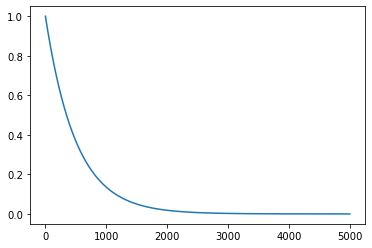

In [ ]:
plt.plot(time, epsilon)
plt.show()

#### <font color='green'>Hence from the epsilon decay graph we observe a good proportion of exploration as well as exploitation for the 5 thousand episodes.</font>

### Let us verify the saved pickle file for model weights

In [ ]:
# Let us define a function to read the saved tracked status and policies
def read_data(filename):
    with open(filename + '.pkl', 'rb') as file:
        saved_data = pickle.load(file)
    return saved_data

In [ ]:
# Let us read the saved model weights
model_data = read_data("model_weights")
model_data

[array([[-4.8850465 , -5.105618  , -4.4233265 , ..., -5.1718965 ,
         -4.940742  , -1.2616936 ],
        [-2.6746433 , -1.0492736 , -4.464993  , ..., -0.27949098,
         -0.9782867 , -4.273647  ],
        [-4.7325673 , -4.761895  , -0.38906795, ..., -3.188845  ,
         -3.451719  , -0.40914068],
        ...,
        [ 2.7416046 , -2.2786736 ,  0.57847977, ..., -4.1076007 ,
          1.7650992 ,  0.27224898],
        [-1.1755786 , -3.0698745 , -2.5685012 , ..., -4.20647   ,
         -1.9961427 , -3.1928434 ],
        [-2.8790717 , -2.1383796 ,  1.1951019 , ..., -2.008021  ,
         -7.187521  , -5.478084  ]], dtype=float32),
 array([ -9.429294  ,  -7.2788405 ,  -6.2554626 ,  -8.0657835 ,
         -8.1572895 , -12.406507  , -10.032312  ,  -9.197435  ,
         -4.2014117 ,  -5.832211  ,  -7.861819  ,  -7.5369325 ,
         -2.8566148 ,  -7.0063524 ,  -6.8664527 ,  -5.4897814 ,
         -8.306651  ,  -7.2804046 ,  -7.4881277 ,  -3.3673847 ,
         -7.241605  ,  -6.215971  ,  -

<center><font color='#ccc'>============================================ End of Assignment ============================================</font></center>